In [1]:
import warnings
warnings.filterwarnings("ignore")
import os
os.environ['CASTLE_BACKEND'] = 'pytorch'
import networkx as nx
#import castle
from castle.common import GraphDAG, independence_tests
from castle.metrics import MetricsDAG
from castle.datasets import IIDSimulation, DAG
from castle.algorithms import PC, GES, ICALiNGAM, GOLEM
from collections import OrderedDict

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr
from scipy.stats import linregress, t
pd.options.mode.chained_assignment = None  # default='warn'
import seaborn as sns

2025-12-06 12:32:42,306 - /Users/camilla/PycharmProjects/causal_rayan/castle/algorithms/__init__.py[line:36] - INFO: You are using ``pytorch`` as the backend.


In [2]:
# Two-file version
COUNTS_CSV = "msa_datacenter_counts.csv"         # outcomes
REGS_CSV   = "msa_regressors_totals.csv"         # regressors

ID_COL_COUNTS = "msa"       # ← exact same as original script
ID_COL_REGS   = "msa"       # ← same here
NAME_COL_COUNTS = None      # unless you actually have a name column

# ------------------------------------------------------------
# 1. Load and merge CSVs
# ------------------------------------------------------------

COUNTS_CSV = "msa_datacenter_counts.csv"   # outcomes
REGS_CSV   = "msa_regressors_totals.csv"   # regressors

# Read both files
counts = pd.read_csv(COUNTS_CSV)
regs   = pd.read_csv(REGS_CSV)

print("Counts columns:", counts.columns.tolist())
print("Regs columns:", regs.columns.tolist())

# Make the ID + name columns consistent
# (adapted from your two-file template to actual column names)
counts = counts.rename(columns={
    "MSA Code":  "MSA",       # ID
    "MSA Title": "MSATitle"   # name
})

# Standardize IDs to 5-digit strings (like the original zfill logic)
counts["MSA"] = counts["MSA"].astype(str).str.zfill(5)
regs["MSA"]   = regs["MSA"].astype(str).str.zfill(5)

# Select which outcome variables to attach from counts
cols_keep = ["MSA", "MSATitle", "datacenter_count", "has_datacenter"]

# Merge regressors + outcomes
data = regs.merge(
    counts[cols_keep],
    on="MSA",
    how="left"
)

# Fill missing outcomes with zeros (same as original template)
data["datacenter_count"] = data["datacenter_count"].fillna(0).astype(int)
data["has_datacenter"]   = data["has_datacenter"].fillna(0).astype(int)

print("\nMerged data head:")
print(data.head())

df = data

Counts columns: ['MSA Code', 'MSA Title', 'datacenter_count', 'has_datacenter']
Regs columns: ['MSA', 'water_sum', 'bqs_mean', 'events_sum', 'evi_mean', 'benefit_flag', 'msa_ret_coal', 'elec_var_ind_all', 'SAMI_energy_exp', 'SAMI_energy_emp_it_total', 'cap_total', 'prox_total']

Merged data head:
     MSA  water_sum   bqs_mean  events_sum   evi_mean  benefit_flag  \
0  C1010      17222  49.050000         724  20.575484             0   
1  C1014        100  39.900000          66  25.996381             1   
2  C1018      28743  68.866667        3272  26.589424             0   
3  C1022        943  37.200000         767  25.943401             0   
4  C1030        544  47.200000         236  22.041479             1   

   msa_ret_coal  elec_var_ind_all  SAMI_energy_exp  SAMI_energy_emp_it_total  \
0             0          0.226509         0.254543                  0.040254   
1             0          0.102691        -0.189371                 -0.103846   
2             0          0.539301  

0 1 [] 0.2997397473818761 1.1744142362176772e-20
0 2 [] -0.1527522723326939 3.374004009446349e-06
0 3 [] 0.31204001516929014 2.447637230944776e-22
0 4 [] 0.07099077841476119 0.03150000773241476
0 5 [] 0.1211004925094275 0.0002227232236065242
0 6 [] 0.4327227486730809 1.6842048808779376e-43
1 2 [] -0.0832026285840874 0.011719577816570192
1 3 [] 0.11611407449936445 0.0004021447046413499
1 4 [] -0.008996971545353439 0.7854459662627085
1 5 [] -0.08910534022475558 0.006692615590010919
1 6 [] 0.18049945838599113 3.2442573647989655e-08
2 3 [] -0.08632401843031054 0.008912759256422674
2 4 [] -0.17791407565021589 6.561760756960012e-08
2 5 [] -0.33532093460071444 1.5574619485250058e-25
2 6 [] -0.12569096570338698 0.0001355629549669757
3 4 [] 0.1670550695185082 3.5724099865818775e-07
3 5 [] 0.06246390112783663 0.05755774202248077
3 6 [] 0.35702423507766595 3.4225992737015303e-29
4 5 [] 0.047961525964939355 0.1464964012812557
4 6 [] 0.19226914242537826 4.295148300994499e-09
5 6 [] -0.0282971429508

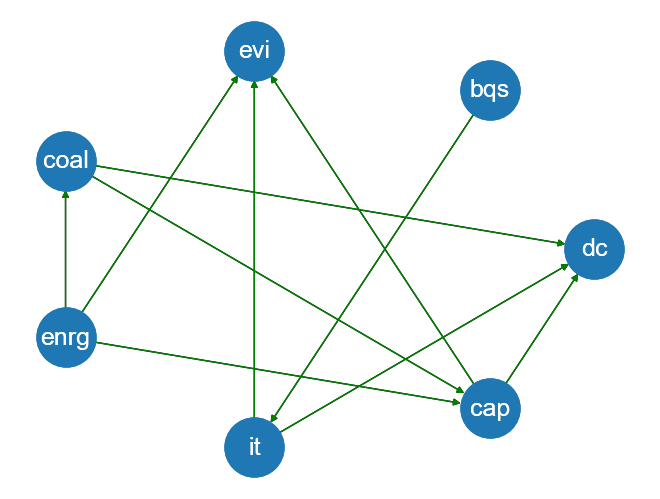

In [3]:
# pc_dataset = np.array(merged_df[["Firearm Prevalence","Gun Shops","Homicides","Firearm Homicides","Armed_Robberies"]])
#pc_dataset = np.array(df[["datacenter_count",'water_sum', 'bqs_mean', 'events_sum', 'evi_mean',
#                           'msa_ret_coal', 'elec_var_ind_all', 'energy_exp_pc',
#                           'emp_it_total_pc', 'cap_total']])
pc_dataset = np.array(df[["datacenter_count", 'bqs_mean', 'evi_mean',
                           'msa_ret_coal', 'SAMI_energy_exp',
                           'SAMI_energy_emp_it_total', 'cap_total']])
pc_MI = PC(ci_test = "Spearman")
pc_MI.learn(pc_dataset)
learned_graph_MI = nx.DiGraph(pc_MI.causal_matrix)

# Relabel the nodes
#MAPPING_MI  = {k: v for k, v in zip(range(10), ['dc', 'Wat', 'bqs', 'rsk', 'evi',
#                           'coal', 'prc', 'enrg',
#                           'it', 'cap'])}
MAPPING_MI  = {k: v for k, v in zip(range(10), ['dc', 'bqs', 'evi',
                           'coal', 'enrg',
                           'it', 'cap'])}
learned_graph_MI  = nx.relabel_nodes(learned_graph_MI, MAPPING_MI, copy=True)

# Plot the graph
nx.draw_circular(
    learned_graph_MI, 
    with_labels=True,
    node_size=1800,
    font_size=18,
    font_color='white'
)
# ----------------------------
# 3. Draw graph with colored edges
# ----------------------------
pos = nx.circular_layout(learned_graph_MI)
# map short names back to indices in `cols`
rev_map = {v: k for k, v in MAPPING_MI.items()}

edge_colors = []
for u, v in learned_graph_MI.edges():
    i = rev_map[u]
    j = rev_map[v]
    r = pc_MI.causal_matrix[i, j]
    if r > 0:
        edge_colors.append('green')
    elif r < 0:
        edge_colors.append('red')
    else:
        edge_colors.append('gray')  # exactly zero or NaN (unlikely)

nx.draw(
    learned_graph_MI,
    pos,
    with_labels=True,
    node_size=1800,
    font_size=18,
    font_color='white',
    edge_color=edge_colors
)